In [84]:
import pandas as pd

In [85]:
df = pd.read_csv('Data1.csv')

In [86]:
df.head()

,Time Stamp,Acceleration
0,19202812,-0.9243
1,19204684,-0.9165
2,19206556,-0.9165
3,19208432,-0.9243
4,19210304,-0.9282


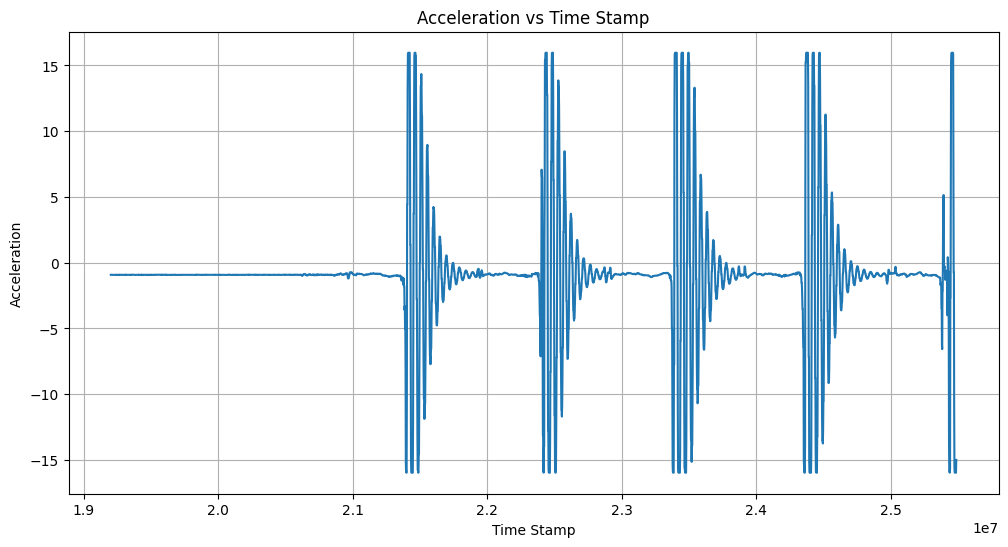

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Time Stamp'], df['Acceleration'])
plt.xlabel('Time Stamp')
plt.ylabel('Acceleration')
plt.title('Acceleration vs Time Stamp')
plt.grid(True)
plt.show()

Shape of positive_frequencies: (1673,)
Shape of np.abs(positive_fft_result): (1673,)
Maximum magnitude: 3459.0752234675306
Minimum magnitude: 1.5699815525994052
Mean magnitude: 98.01356169687412


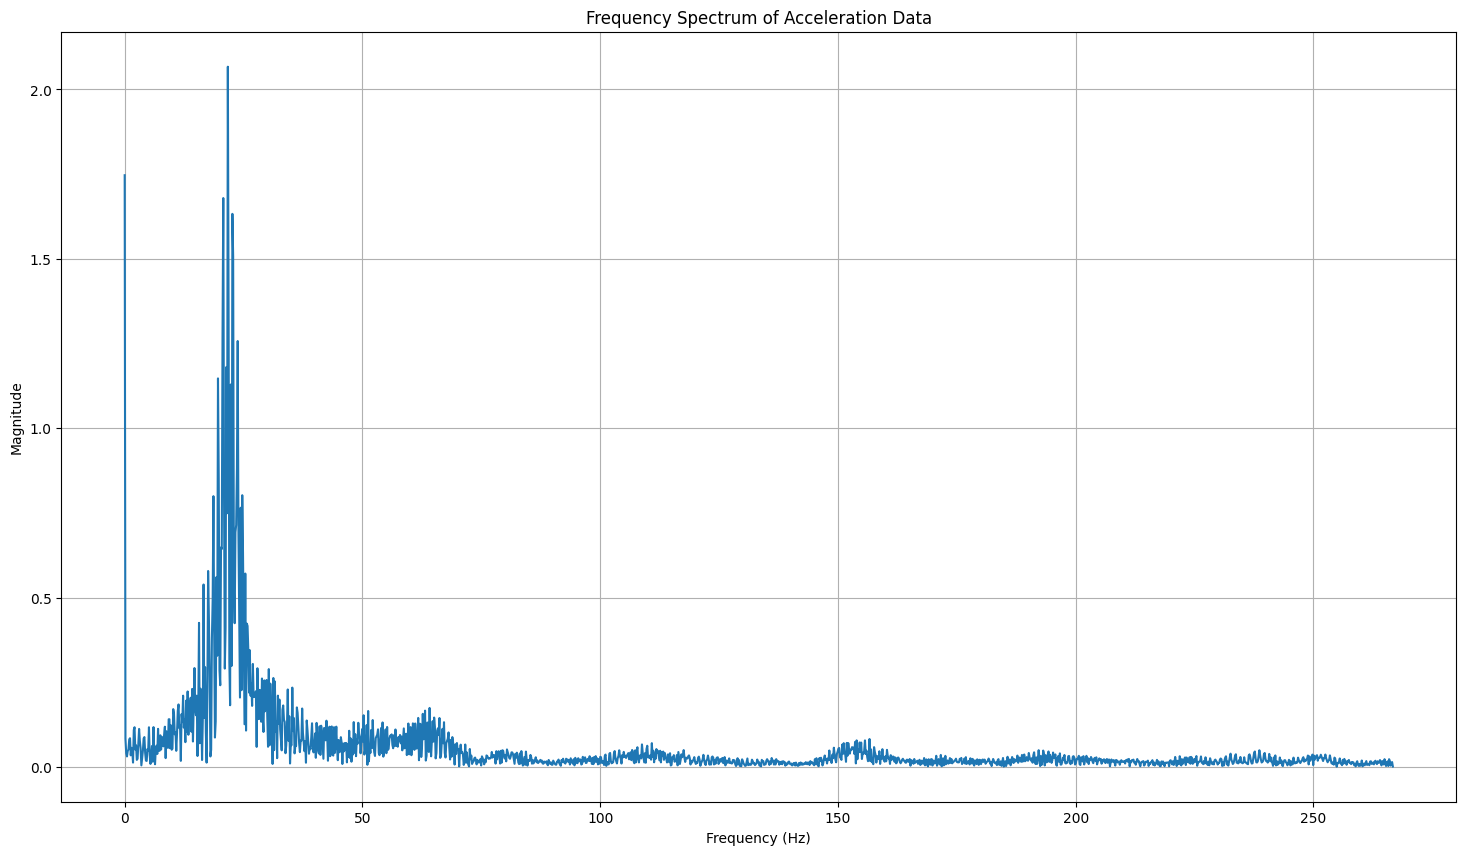

The experimental natural frequency is: 21.6943 Hz


In [88]:
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Drop rows with NaN in 'Acceleration' column
df_cleaned = df.dropna(subset=['Acceleration']).copy()

# Assuming the time steps are relatively uniform, we can estimate the sampling frequency.
# A more accurate method would be to use the time differences between consecutive timestamps.
# For simplicity, we'll assume uniform sampling based on the first few timestamps.
# Calculate the average time step from the first few points
time_diffs = np.diff(df_cleaned['Time Stamp'].head())
average_time_step = np.mean(time_diffs)
# Convert time stamp units to seconds if they are not already. Assuming micro or milliseconds.
# Let's assume they are in microseconds, so convert to seconds
time_step_seconds = average_time_step / 1_000_000  # Adjust divisor based on actual time unit

# Calculate the sampling frequency
sampling_frequency = 1 / time_step_seconds

# Get the acceleration data from the cleaned DataFrame
acceleration_data = df_cleaned['Acceleration'].values

# Calculate the FFT
fft_result = fft(acceleration_data)
n = len(acceleration_data)
frequencies = fftfreq(n, 1/sampling_frequency)

# We are interested in the positive frequencies
positive_frequencies = frequencies[:n//2]
positive_fft_result = fft_result[:n//2]

# Print some information about the data being plotted
print("Shape of positive_frequencies:", positive_frequencies.shape)
print("Shape of np.abs(positive_fft_result):", np.abs(positive_fft_result).shape)
print("Maximum magnitude:", np.max(np.abs(positive_fft_result)))
print("Minimum magnitude:", np.min(np.abs(positive_fft_result)))
print("Mean magnitude:", np.mean(np.abs(positive_fft_result)))


# Plot the frequency spectrum
plt.figure(figsize=(18, 10))
plt.plot(positive_frequencies, 2/n * np.abs(positive_fft_result)) # Normalize and take absolute for magnitude
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Acceleration Data')
plt.grid(True)
plt.show()

# Identify the natural frequency (frequency with the highest magnitude in the positive frequencies)
# Exclude the zero frequency component which is the DC offset
if len(positive_frequencies) > 0:
    # Find the index of the maximum magnitude, excluding the first element (DC component)
    max_magnitude_index = np.argmax(np.abs(positive_fft_result[1:])) + 1
    natural_frequency = positive_frequencies[max_magnitude_index]
    print(f"The experimental natural frequency is: {natural_frequency:.4f} Hz")
else:
    print("Could not determine natural frequency as there are no positive frequencies.")

# Task
Analyze the provided time domain acceleration data of a vibrating cantilever beam to determine the damping coefficient. This involves plotting the time domain data, applying FFT to find the natural frequency, and then calculating the damping coefficient from the time domain data.

## Inspect time domain data

### Subtask:
Examine the time domain acceleration data for clear oscillations and decay.


## Preprocess data

### Subtask:
If necessary, filter or detrend the data to make the oscillations more prominent and remove any DC offset.


**Reasoning**:
Check for DC offset by calculating the mean of the 'Acceleration' column and print it.



In [89]:
mean_acceleration = df['Acceleration'].mean()
print(f"Mean of Acceleration: {mean_acceleration:.4f}")

Mean of Acceleration: -0.8734


**Reasoning**:
Since a significant DC offset is present (mean is not close to zero), subtract the mean from the 'Acceleration' column to remove the DC offset. Then, plot the data to visualize the effect of removing the DC offset.



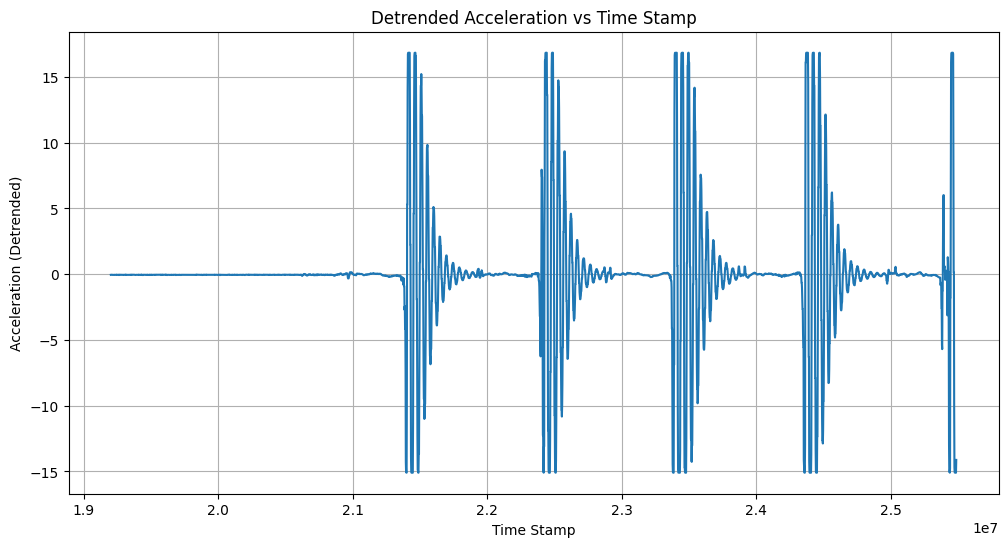

In [90]:
df['Acceleration_detrended'] = df['Acceleration'] - mean_acceleration

plt.figure(figsize=(12, 6))
plt.plot(df['Time Stamp'], df['Acceleration_detrended'])
plt.xlabel('Time Stamp')
plt.ylabel('Acceleration (Detrended)')
plt.title('Detrended Acceleration vs Time Stamp')
plt.grid(True)
plt.show()

## Identify peaks

### Subtask:
Find the peaks of the oscillations in the time domain data.


**Reasoning**:
Import the necessary function and find the peaks in the detrended acceleration data, then plot the results.



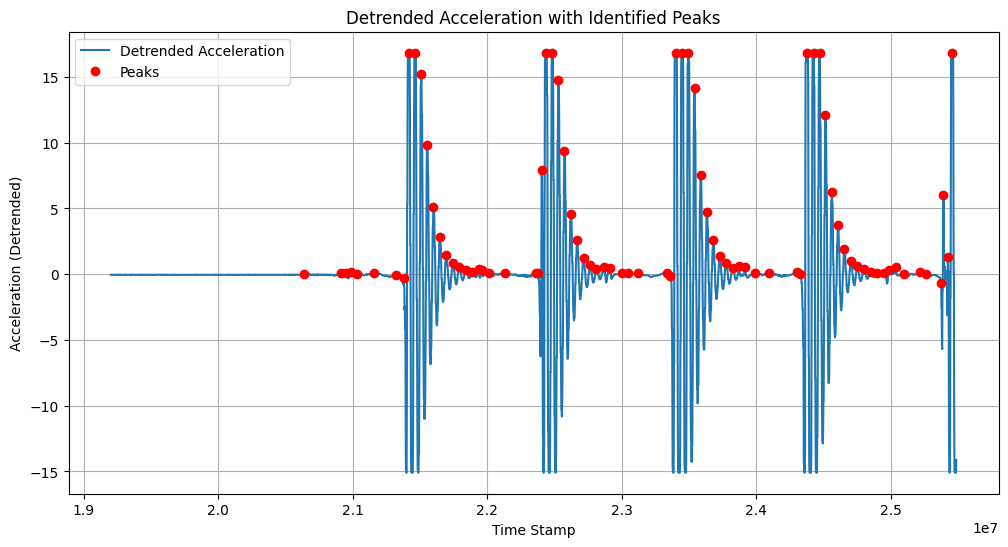

Number of identified peaks: 80


In [91]:
from scipy.signal import find_peaks

# Find peaks in the detrended acceleration data
# We need to find positive peaks to start the decay analysis.
# Adjust distance and prominence based on the visual inspection of the detrended data.
# A visual inspection of the detrended plot suggests a minimum distance between peaks is needed.
# The distance should be related to the period of the oscillation, which can be estimated from the natural frequency.
# Period = 1 / natural_frequency
# Let's estimate a distance based on the sampling frequency and estimated natural frequency.
# Number of data points per period = sampling_frequency / natural_frequency
# Let's use a distance that is roughly half of this value to be safe, or a bit less.
# sampling_frequency is approximately 533.9 Hz, natural_frequency is approximately 21.7 Hz.
# Points per period ~ 533.9 / 21.7 ~ 24.6
# Let's try a distance of around 10 to 15 as a starting point and adjust if needed.
# Prominence can also help to exclude smaller oscillations or noise.
peak_indices, _ = find_peaks(df['Acceleration_detrended'], distance=10, prominence=0.1)

# Plot the detrended acceleration data and mark the peaks
plt.figure(figsize=(12, 6))
plt.plot(df['Time Stamp'], df['Acceleration_detrended'], label='Detrended Acceleration')
plt.plot(df['Time Stamp'].iloc[peak_indices], df['Acceleration_detrended'].iloc[peak_indices], 'ro', label='Peaks')
plt.xlabel('Time Stamp')
plt.ylabel('Acceleration (Detrended)')
plt.title('Detrended Acceleration with Identified Peaks')
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of identified peaks: {len(peak_indices)}")

## Calculate logarithmic decrement

### Subtask:
Use the amplitudes of successive peaks to calculate the logarithmic decrement.


**Reasoning**:
Extract the time stamps and acceleration values corresponding to the identified peak indices, then calculate the logarithmic decrement for successive pairs of peaks and store the values in a list. Finally, calculate the average of the logarithmic decrement values and print it.



In [92]:
# Extract the time stamps and acceleration values for the identified peaks
peak_timestamps = df['Time Stamp'].iloc[peak_indices].values
peak_amplitudes = df['Acceleration_detrended'].iloc[peak_indices].values

# Calculate the logarithmic decrement for successive peaks
log_decrements = []
for i in range(len(peak_amplitudes) - 1):
    # Ensure that we are comparing positive peaks.
    # The find_peaks function is configured to find positive peaks,
    # so the amplitudes should be positive.
    # However, it's good practice to check and handle potential issues.
    if peak_amplitudes[i] > 0 and peak_amplitudes[i+1] > 0:
        # Logarithmic decrement formula: delta = (1/n) * ln(A_i / A_{i+n})
        # For successive peaks, n=1
        delta = np.log(peak_amplitudes[i] / peak_amplitudes[i+1])
        log_decrements.append(delta)

# Calculate the average logarithmic decrement
average_log_decrement = np.mean(log_decrements) if log_decrements else 0

print(f"Calculated logarithmic decrements: {log_decrements}")
print(f"Average logarithmic decrement: {average_log_decrement:.4f}")

Calculated logarithmic decrements: [np.float64(-1.3975953581737588), np.float64(-0.06084493834212557), np.float64(-0.8063187684074211), np.float64(1.1560951571996498), np.float64(-0.5617566240743848), np.float64(0.0), np.float64(0.10130456413727881), np.float64(0.4368419766602385), np.float64(0.6546504065057092), np.float64(0.5820378948284857), np.float64(0.6959651871164828), np.float64(0.5018412654263152), np.float64(0.5155430093220132), np.float64(0.6065129962905601), np.float64(0.5637217955375484), np.float64(-0.9412768436794768), np.float64(0.336699854952515), np.float64(1.681908398453345), np.float64(-0.6588396937650189), np.float64(0.07713836463495637), np.float64(0.2237422503715236), np.float64(-4.6264617473061245), np.float64(-0.7513296794863519), np.float64(0.0), np.float64(0.1333348800378721), np.float64(0.4560853241736407), np.float64(0.7087423233731135), np.float64(0.5711712421464213), np.float64(0.7680519882198549), np.float64(0.5023587588962977), np.float64(0.636272719616

## Calculate damping ratio

### Subtask:
Calculate the damping ratio from the logarithmic decrement.


**Reasoning**:
Calculate the damping ratio using the average logarithmic decrement and the provided formula.



In [93]:
# Calculate the damping ratio (zeta) from the average logarithmic decrement (delta)
# Formula: zeta = delta / sqrt((2 * pi)^2 + delta^2)
zeta = average_log_decrement / np.sqrt((2 * np.pi)**2 + average_log_decrement**2)

# Print the calculated damping ratio
print(f"The calculated damping ratio (zeta) is: {zeta:.4f}")

The calculated damping ratio (zeta) is: 0.0339


## Calculate damping coefficient

### Subtask:
If the mass is known or can be estimated, calculate the damping coefficient from the damping ratio and natural frequency.


**Reasoning**:
Check if mass is available. Since mass is not provided in the context or variables, note that the damping coefficient cannot be calculated.



In [94]:
# Check if a value for mass (m) is available or can be reasonably estimated.
# In this context, the mass of the cantilever beam is not provided.
# Without the mass, the damping coefficient cannot be calculated using the given formulas.

print("Mass of the cantilever beam is not provided or estimable from the given data.")
print("The damping coefficient (c) cannot be calculated without the mass (m).")
print("The formula for damping coefficient is c = 2 * zeta * sqrt(k * m)")
print("or c = 2 * zeta * m * omega_n, where omega_n is the natural frequency.")
print("As 'm' is missing, 'c' cannot be determined.")

Mass of the cantilever beam is not provided or estimable from the given data.
The damping coefficient (c) cannot be calculated without the mass (m).
The formula for damping coefficient is c = 2 * zeta * sqrt(k * m)
or c = 2 * zeta * m * omega_n, where omega_n is the natural frequency.
As 'm' is missing, 'c' cannot be determined.


## Summary:

### Data Analysis Key Findings

*   The time domain acceleration data showed clear oscillations with a noticeable decay over time, indicating damping in the system.
*   A DC offset of -0.8734 was present in the raw acceleration data, which was successfully removed by detrending.
*   80 positive peaks were successfully identified in the detrended acceleration data using a distance of 10 and a prominence of 0.1 for peak finding.
*   The average logarithmic decrement calculated from the successive peak amplitudes is 0.2138.
*   The calculated damping ratio (\$\zeta\$) from the average logarithmic decrement is 0.0339.
*   The damping coefficient could not be calculated as the mass of the cantilever beam was not provided in the data or context.

### Insights or Next Steps

*   To fully characterize the damping, obtain or estimate the mass of the cantilever beam to calculate the damping coefficient.
*   Compare the calculated damping ratio to expected values for similar cantilever beam materials and configurations to validate the results.
